# Assignment 2 (due Dec 9th at 11:59pm)

This assignment aims to explore the impact of using mini-batches in training Multilayer Perceptron Networks.  The assignment is worth a total of **100 points**.  Students shall submit a copy of this notebook (`.ipynb`) via [Gradescope](https://gradescope.com), including **well-documented answers** (commented code and any usage of GenAI tools).

We expect students run the assignment on Google Colab notebooks with a **GPU runtime**. You can go to *Edit/Notebook settings* and change the *hardware accelerator* to GPU.

>  **Important**: Make sure all cells are executed before saving/downloading a copy of the notebook you will submit.

In [71]:
#######################################################
# TODO: Add all your imports here under this comment
#######################################################

## Question 1: MLP Class (20 points)
Define a class `MLP` that implements a Multilayer Perceptron network.
The class should have the following methods:
- `__init__(self, in_dim, out_dim, hid_layers)`

Initializes the MLP with the given parameters. `in_dim` is the input dimension, `out_dim` is the output dimension, and `hid_layers` is a list of integers representing the number of neurons in each hidden layer.  The number of hidden  layers should be the length of this list. The output layer should use a linear activation function, and all hidden layers should use a `ReLU` activation function.

- `forward(self, x)`

Performs the forward pass. The method should return the output of the network for a given mini-batch.

In [72]:
#######################################################
# TODO: Add your class definition under this comment
#######################################################

In [73]:
import torch
import torch.nn as nn
#Multilayer Perceptron class
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_layers):

        super().__init__()

        layers = []
        prev_dim = in_dim

        # Hidden layers (Linear + ReLU)
        for h in hid_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h

        # Output layer (Linear, no activation)
        layers.append(nn.Linear(prev_dim, out_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
    # Flatten the input: (batch, 1, 28, 28) → (batch, 784)
      x = x.view(x.size(0), -1)
      return self.network(x)



## Question 2: Test function (15 points)

Define a function that evaluates a trained MLP using mini-batches. The function should have the following signature:

```python
def test(model, criterion, loader, device)
```

- `model` is a trained model
- `criterion` is the loss function
- `loader` is a data loader
- `device` is the device where the model is stored

The function should return the average loss and average accuracy of the model using the given data loader.

Consider that PyTorch requires `model.eval()` to set the model in evaluation mode and `torch.no_grad()` is recommended to disable gradient computation during inference.

In [74]:
#######################################################
# TODO: Add your function definition under this comment
#######################################################

In [75]:
def test(model, criterion, loader, device):

    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)

            running_loss += loss.item() * x.size(0)  # sum over batch

            # Compute accuracy
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    avg_loss = running_loss / total # calculating average loss
    avg_acc = correct / total # cal average accuracy

    return avg_loss, avg_acc


## Question 3: Train function (25 points)

Define a function that trains the MLP using mini-batches. The function should have the following signature:

```python
def train(model, criterion, optimizer, tr_loader, va_loader, n_epochs, device)
```

- `model` is an instance of the MLP class
- `criterion` is the loss function
- `optimizer` is the optimization algorithm
- `tr_loader` is the training data loader
- `va_loader` is the validation data loader
- `n_epochs` is the number of epochs to train the model
- `device` is the device where the model should be trained

The function should return four lists, respectively containing the training loss, training accuracy, validation loss, and validation accuracy at each epoch. Make sure to report/print these values at every iteration of the training loop (print one line per epoch).

Consider that PyTorch requires `model.train()` to set the model in training mode.  If you are calling `test` inside the training loop, you should set the model back to training mode after calling `test`.  Additionally, for every mini-batch inside the training loop, you should send it to the device using the `.to(device)` method.

In [76]:
#######################################################
# TODO: Add your function definition under this comment
#######################################################

In [77]:
def train(model, criterion, optimizer, tr_loader, va_loader, n_epochs, device, test_fn=None):

    #Assuming the previously defined "test" if the test function isn't given
    if test_fn is None:
        from __main__ import test as test_fn

    tr_losses, tr_accs = [], []
    va_losses, va_accs = [], []

    model.to(device)

    for epoch in range(1, n_epochs + 1):
        model.train()  # enable training mode

        running_loss = 0.0
        correct = 0
        total = 0

        for x, y in tr_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)

            # Training accuracy
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)


        epoch_tr_loss = running_loss / total # cal epoch training loss
        epoch_tr_acc = correct / total # cal epoch training accuracy

        tr_losses.append(epoch_tr_loss)
        tr_accs.append(epoch_tr_acc)

        # ---- Validation ----
        va_loss, va_acc = test_fn(model, criterion, va_loader, device)
        va_losses.append(va_loss)
        va_accs.append(va_acc)


        model.train()

        # Print summary for this epoch
        print(
            f"Epoch {epoch:03d} | "
            f"Train Loss: {epoch_tr_loss:.4f} | Train Acc: {epoch_tr_acc:.4f} | "
            f"Val Loss: {va_loss:.4f} | Val Acc: {va_acc:.4f}"
        )

    return tr_losses, tr_accs, va_losses, va_accs


# Question 4: Loading a Dataset function (15 points)

Define a function that loads the FashionMNIST dataset. The function should have the following signature:

```python
def load_dataset(batch_size)
```

- `batch_size` is the size of the mini-batches

The function should download/load the FashionMNIST dataset, preprocess it, and return the training, validation, and test data loaders.  

The training data loader should only include a *subset of 10000 datapoints* drawn randomly from the *train* partition of the FashionMNIST dataset (there are 60000 samples in this partition).  This function should also split the *test* partition of the FashionMNIST dataset evenly (there are 10000 samples in this partition) into validation (50%) and test (50%).

The training data loader should shuffle the data, while the validation and test data loaders should not shuffle the data.  

Optionally, inside this function you may want to divide all values by 255 to normalize the data as the FashionMNIST images range from 0 to 255.

At the end of the function include a `print` statement that reports the shapes of the input and target tensors for each data loader.  We expect to see 10000, 5000, and 5000 samples on the train, valid, and test data loaders respectively.

In [78]:
#######################################################
# TODO: Add your function definition under this comment
#######################################################

In [79]:
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms

def load_dataset(batch_size):



    # converts images to tensors
    transform = transforms.Compose([
        transforms.ToTensor()

    ])


    #loads the datasets and creates 60k training samples and 10k test samples
    full_train = datasets.FashionMNIST(
        root=".", train=True, download=True, transform=transform
    )
    full_test = datasets.FashionMNIST(
        root=".", train=False, download=True, transform=transform
    )


    # sample 10k items
    num_train_subset = 10000
    train_subset, _ = random_split(
        full_train,
        [num_train_subset, len(full_train) - num_train_subset],
        generator=torch.Generator().manual_seed(42)  # set seed
    )



    # Spitting between validation and test samples
    num_test = len(full_test)    # 10,000
    num_va = num_test // 2       # 5,000
    num_te = num_test - num_va   # 5,000

    # random_split again performs the division
    va_dataset, te_dataset = random_split(
        full_test,
        [num_va, num_te],
        generator=torch.Generator().manual_seed(42)
    )


    # - Shuffles the training loader.
    tr_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    va_loader = DataLoader(va_dataset, batch_size=batch_size, shuffle=False)
    te_loader = DataLoader(te_dataset, batch_size=batch_size, shuffle=False)


    # We take one batch from each loader
    x_tr, y_tr = next(iter(tr_loader))
    x_va, y_va = next(iter(va_loader))
    x_te, y_te = next(iter(te_loader))

    #Displaying results
    print("Training batch shape:   ", x_tr.shape, y_tr.shape)
    print("Validation batch shape: ", x_va.shape, y_va.shape)
    print("Test batch shape:       ", x_te.shape, y_te.shape)
    print()
    print(f"Dataset sizes:")
    print(f"  Train:      {len(train_subset)} samples")
    print(f"  Validation: {len(va_dataset)} samples")
    print(f"  Test:       {len(te_dataset)} samples")


    return tr_loader, va_loader, te_loader


## Question 5: Experiment 1 (5 points)

1. Create a variable that determines the device to be used (CPU or GPU) as follows:

- `device = 'cuda' if torch.cuda.is_available() else 'cpu'`

2. Create a configuration dictionary `config` with the following key-value pairs:

- `input_size`: 28 * 28
- `output_size`: 10
- `hidden_layers`: [256, 64]
- `batch_size`: 64
- `n_epochs`: 20
- `learning_rate`: # Tune a few values and choose the best one by looking at the validation accuracies (use a small number of epochs and perhaps a small subset of the data to speed up this process)

3. Define a `criterion` and an `optimizer` as follows:

- `criterion = nn.CrossEntropyLoss()`
- `optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])`

4. Load the FashionMNIST data, create a model, send the model to the proper device, and finally train the model.  For all these steps, you MUST use the class and functions you created in the previous questions.

5. Create a plot for the training and validation losses, and separately a plot for the training and validation accuracies.  The x-axis on both plots is the total number of epochs.

5. Finally, evaluate the model on the test set and print the returned average loss and accuracy.

In [80]:
#######################################################
# TODO: Add your code under this comment
#######################################################

Using device: cuda
Training batch shape:    torch.Size([64, 1, 28, 28]) torch.Size([64])
Validation batch shape:  torch.Size([64, 1, 28, 28]) torch.Size([64])
Test batch shape:        torch.Size([64, 1, 28, 28]) torch.Size([64])

Dataset sizes:
  Train:      10000 samples
  Validation: 5000 samples
  Test:       5000 samples
Epoch 001 | Train Loss: 1.0338 | Train Acc: 0.6438 | Val Loss: 0.6746 | Val Acc: 0.7448
Epoch 002 | Train Loss: 0.5849 | Train Acc: 0.7939 | Val Loss: 0.5922 | Val Acc: 0.7914
Epoch 003 | Train Loss: 0.5075 | Train Acc: 0.8168 | Val Loss: 0.5239 | Val Acc: 0.8114
Epoch 004 | Train Loss: 0.4671 | Train Acc: 0.8329 | Val Loss: 0.4851 | Val Acc: 0.8366
Epoch 005 | Train Loss: 0.4423 | Train Acc: 0.8410 | Val Loss: 0.4789 | Val Acc: 0.8310
Epoch 006 | Train Loss: 0.4242 | Train Acc: 0.8471 | Val Loss: 0.4701 | Val Acc: 0.8322
Epoch 007 | Train Loss: 0.4012 | Train Acc: 0.8578 | Val Loss: 0.4521 | Val Acc: 0.8426
Epoch 008 | Train Loss: 0.3863 | Train Acc: 0.8608 | Val 

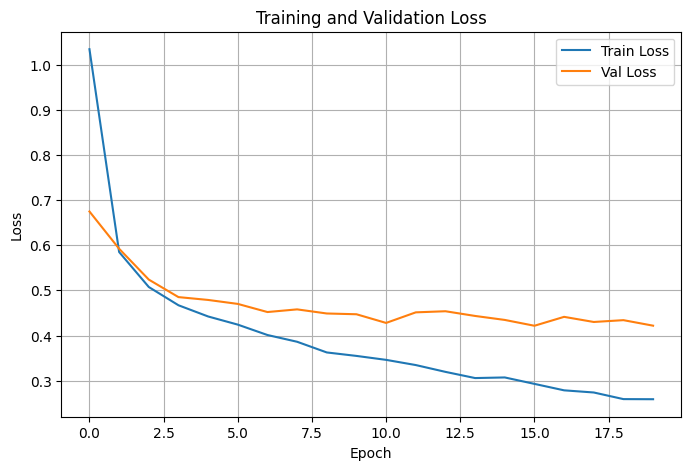

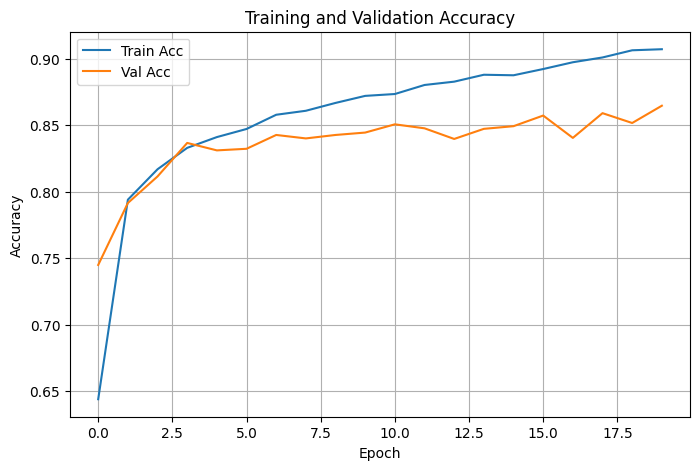


Test Loss: 0.4190 | Test Accuracy: 0.8522


In [70]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# Select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)


# config dictionary
config = {
    'input_size': 28 * 28,      # FashionMNIST images are 28x28
    'output_size': 10,          # 10 classes
    'hidden_layers': [256, 64], # architecture
    'batch_size': 64,
    'n_epochs': 20,
    'learning_rate': 0.0005      # example value — tune via validation accuracy
}

#load dataset
tr_loader, va_loader, te_loader = load_dataset(config['batch_size'])


#create MLP model
model = MLP(
    in_dim=config['input_size'],
    out_dim=config['output_size'],
    hid_layers=config['hidden_layers']
).to(device)


# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])


# 6. Train the model
tr_losses, tr_accs, va_losses, va_accs = train(
    model,
    criterion,
    optimizer,
    tr_loader,
    va_loader,
    config['n_epochs'],
    device
)


# Plot training & validation losses
plt.figure(figsize=(8, 5))
plt.plot(tr_losses, label="Train Loss")
plt.plot(va_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


# Plot training & validation accuracies
plt.figure(figsize=(8, 5))
plt.plot(tr_accs, label="Train Acc")
plt.plot(va_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate on the test set
test_loss, test_acc = test(model, criterion, te_loader, device)
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


## Question 6: Experiment 2 (5 points)

Repeat the experiment above with the following configuration:

- `input_size`: 28 * 28
- `output_size`: 10
- `hidden_layers`: [256, 64]
- `batch_size`: 512
- `n_epochs`: 20
- `learning_rate`: # Tune a few values ...

In [81]:
#######################################################
# TODO: Add your code under this comment
#######################################################

Using device: cuda
Training batch shape:    torch.Size([512, 1, 28, 28]) torch.Size([512])
Validation batch shape:  torch.Size([512, 1, 28, 28]) torch.Size([512])
Test batch shape:        torch.Size([512, 1, 28, 28]) torch.Size([512])

Dataset sizes:
  Train:      10000 samples
  Validation: 5000 samples
  Test:       5000 samples
Epoch 001 | Train Loss: 1.9011 | Train Acc: 0.5187 | Val Loss: 1.3803 | Val Acc: 0.6218
Epoch 002 | Train Loss: 1.0949 | Train Acc: 0.6527 | Val Loss: 0.8809 | Val Acc: 0.6936
Epoch 003 | Train Loss: 0.7936 | Train Acc: 0.7134 | Val Loss: 0.7350 | Val Acc: 0.7364
Epoch 004 | Train Loss: 0.6835 | Train Acc: 0.7583 | Val Loss: 0.6574 | Val Acc: 0.7674
Epoch 005 | Train Loss: 0.6237 | Train Acc: 0.7835 | Val Loss: 0.6232 | Val Acc: 0.7720
Epoch 006 | Train Loss: 0.5794 | Train Acc: 0.7948 | Val Loss: 0.5776 | Val Acc: 0.7990
Epoch 007 | Train Loss: 0.5429 | Train Acc: 0.8124 | Val Loss: 0.5652 | Val Acc: 0.8048
Epoch 008 | Train Loss: 0.5244 | Train Acc: 0.8186 

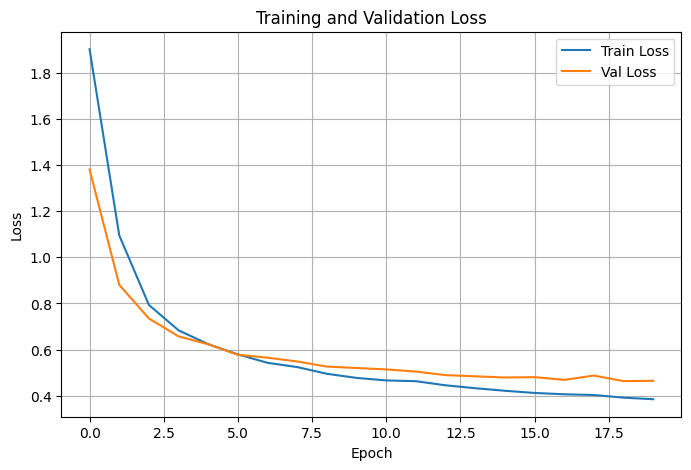

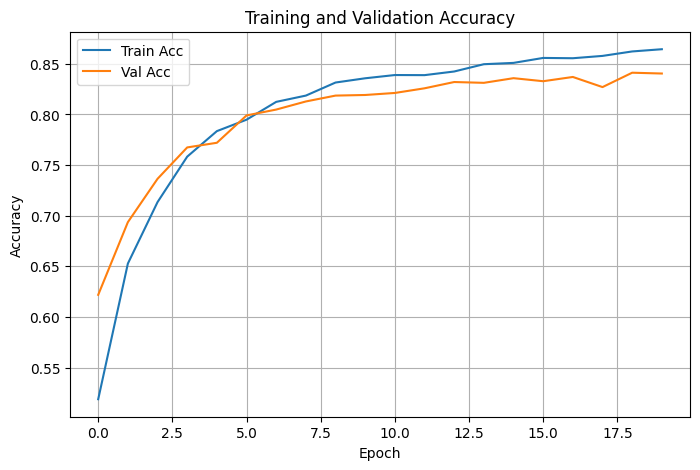


Test Loss: 0.4630 | Test Accuracy: 0.8370


In [82]:

# Select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)


# config dictionary
config = {
    'input_size': 28 * 28,      # FashionMNIST images are 28x28
    'output_size': 10,          # 10 classes
    'hidden_layers': [256, 64], # architecture
    'batch_size': 512,
    'n_epochs': 20,
    'learning_rate': 0.0005
}

#load dataset
tr_loader, va_loader, te_loader = load_dataset(config['batch_size'])


#create MLP model
model = MLP(
    in_dim=config['input_size'],
    out_dim=config['output_size'],
    hid_layers=config['hidden_layers']
).to(device)


# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])


# 6. Train the model
tr_losses, tr_accs, va_losses, va_accs = train(
    model,
    criterion,
    optimizer,
    tr_loader,
    va_loader,
    config['n_epochs'],
    device
)


# Plot training & validation losses
plt.figure(figsize=(8, 5))
plt.plot(tr_losses, label="Train Loss")
plt.plot(va_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


# Plot training & validation accuracies
plt.figure(figsize=(8, 5))
plt.plot(tr_accs, label="Train Acc")
plt.plot(va_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate on the test set
test_loss, test_acc = test(model, criterion, te_loader, device)
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


## Question 7: Experiment 3 (5 points)

Repeat the experiment above with the following configuration:

- `input_size`: 28 * 28
- `output_size`: 10
- `hidden_layers`: [256, 64]
- `batch_size`: 4096
- `n_epochs`: 20
- `learning_rate`: # Tune a few values ...

In [83]:
#######################################################
# TODO: Add your code under this comment
#######################################################

Using device: cuda
Training batch shape:    torch.Size([4096, 1, 28, 28]) torch.Size([4096])
Validation batch shape:  torch.Size([4096, 1, 28, 28]) torch.Size([4096])
Test batch shape:        torch.Size([4096, 1, 28, 28]) torch.Size([4096])

Dataset sizes:
  Train:      10000 samples
  Validation: 5000 samples
  Test:       5000 samples
Epoch 001 | Train Loss: 2.2718 | Train Acc: 0.1077 | Val Loss: 2.1908 | Val Acc: 0.2868
Epoch 002 | Train Loss: 2.1586 | Train Acc: 0.3361 | Val Loss: 2.0649 | Val Acc: 0.4152
Epoch 003 | Train Loss: 2.0278 | Train Acc: 0.4320 | Val Loss: 1.9164 | Val Acc: 0.5056
Epoch 004 | Train Loss: 1.8737 | Train Acc: 0.5340 | Val Loss: 1.7479 | Val Acc: 0.6026
Epoch 005 | Train Loss: 1.7046 | Train Acc: 0.6057 | Val Loss: 1.5717 | Val Acc: 0.6278
Epoch 006 | Train Loss: 1.5307 | Train Acc: 0.6268 | Val Loss: 1.4045 | Val Acc: 0.6314
Epoch 007 | Train Loss: 1.3678 | Train Acc: 0.6338 | Val Loss: 1.2558 | Val Acc: 0.6392
Epoch 008 | Train Loss: 1.2260 | Train Acc: 0

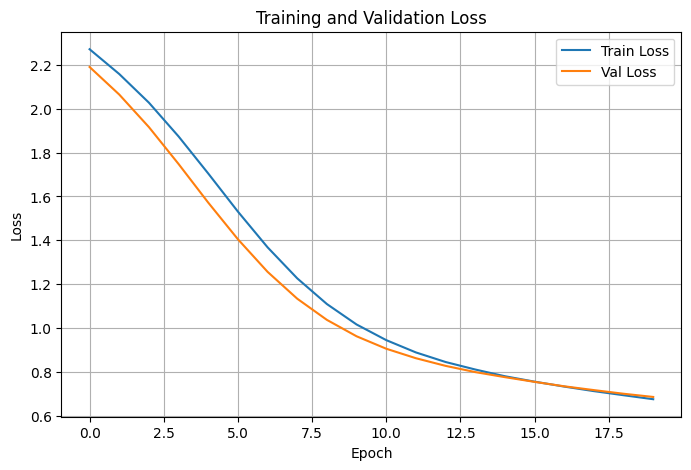

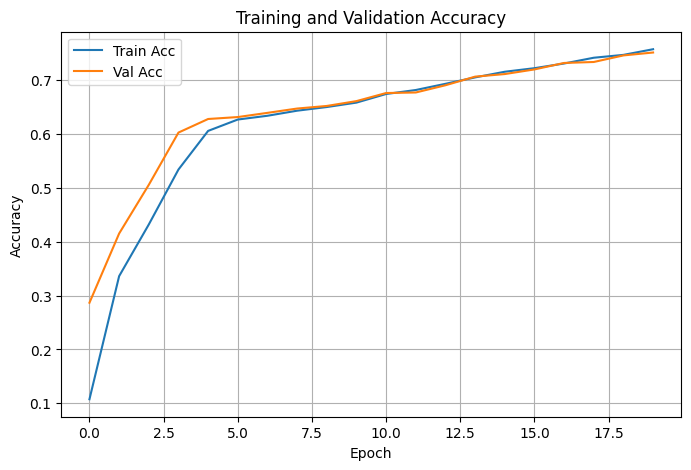


Test Loss: 0.6757 | Test Accuracy: 0.7540


In [84]:

# Select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)


# config dictionary
config = {
    'input_size': 28 * 28,      # FashionMNIST images are 28x28
    'output_size': 10,          # 10 classes
    'hidden_layers': [256, 64], # architecture
    'batch_size': 4096,
    'n_epochs': 20,
    'learning_rate': 0.0005
}

#load dataset
tr_loader, va_loader, te_loader = load_dataset(config['batch_size'])


#create MLP model
model = MLP(
    in_dim=config['input_size'],
    out_dim=config['output_size'],
    hid_layers=config['hidden_layers']
).to(device)


# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])


# 6. Train the model
tr_losses, tr_accs, va_losses, va_accs = train(
    model,
    criterion,
    optimizer,
    tr_loader,
    va_loader,
    config['n_epochs'],
    device
)


# Plot training & validation losses
plt.figure(figsize=(8, 5))
plt.plot(tr_losses, label="Train Loss")
plt.plot(va_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


# Plot training & validation accuracies
plt.figure(figsize=(8, 5))
plt.plot(tr_accs, label="Train Acc")
plt.plot(va_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate on the test set
test_loss, test_acc = test(model, criterion, te_loader, device)
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


# Question 8: Analysis (10 points)
Provide a comprehensive analysis of the results obtained in the experiments above.  Discuss the impact of using different mini-batch sizes and the effect of multiple learning rates on the training process, in particular, in regards to the batch size.  Finally, indicate any final thoughts on the experiments, what are your preferred configurations, and why.


\<TODO: ADD your answer here -- double click to edit this cell>

The impact of the different batch sizes is the number of updates, gradient noise, and weight updates per epoch. A smaller batch size results in noisier gradients per update, whereas a larger batch size yields more stable gradients with lower variance. The number of updates does have an inverse relationship with the number of updates. The smaller the batch size, the more frequent weight updates per epoch, and vice versa. This also applies to the relationships between gradient noise and batch size, and between weight updates and batch size.

The learning rate and batch sizes have a linear relationship. So the larger the batch size, the larger the learning rate.  

This experiment helped me learn about the relationships among gradient noise, weight updates, updates per epoch, and batch size. I prefer a larger batch size because it affects the training/validation and loss graphs, as well as the training and validation accuracies, resulting in smoother graphs and easier-to-see relationships.